In [35]:
# pip install psycopg2-binary in mlenv
# Create config.py file with postgres password as db_password
# Create postgres database called COVID_Risk_Final_Project on POstgreSQL 13 server

In [36]:
# Import the requests library.
import requests
import pandas as pd
from bs4 import BeautifulSoup
import requests
import time
from sqlalchemy import create_engine
import numpy as np

In [3]:
# Read NYT data into dataframe
nyt_data = 'https://group3data.s3.us-west-2.amazonaws.com/us-counties.csv'
nyt_data_df = pd.read_csv(nyt_data)
nyt_data_df

,date,county,state,fips,cases,deaths
0,2020-01-21,Snohomish,Washington,53061.0,1,0.0
1,2020-01-22,Snohomish,Washington,53061.0,1,0.0
2,2020-01-23,Snohomish,Washington,53061.0,1,0.0
3,2020-01-24,Cook,Illinois,17031.0,1,0.0
4,2020-01-24,Snohomish,Washington,53061.0,1,0.0
...,...,...,...,...,...,...
1888090,2021-11-05,Sweetwater,Wyoming,56037.0,7695,91.0
1888091,2021-11-05,Teton,Wyoming,56039.0,5243,14.0
1888092,2021-11-05,Uinta,Wyoming,56041.0,3901,27.0
1888093,2021-11-05,Washakie,Wyoming,56043.0,1780,35.0


In [4]:
# Convert the date column in the NYT data to a datetime object using pd.to_datetime
nyt_data_df['date'] = pd.to_datetime(nyt_data_df['date'])
nyt_data_df.head()

,date,county,state,fips,cases,deaths
0,2020-01-21,Snohomish,Washington,53061.0,1,0.0
1,2020-01-22,Snohomish,Washington,53061.0,1,0.0
2,2020-01-23,Snohomish,Washington,53061.0,1,0.0
3,2020-01-24,Cook,Illinois,17031.0,1,0.0
4,2020-01-24,Snohomish,Washington,53061.0,1,0.0


In [5]:
# 1. Remove the data for dates before 7-31-20 and after 10-22-21
# 2. Bin the date column by weeks ending every friday
# 3. Sum the cases and deaths columns for each week binned

# Step 1:
nyt_data_filtered = nyt_data_df[nyt_data_df['date'] >= '2020-07-25']
nyt_data_filtered = nyt_data_filtered[nyt_data_filtered['date'] <= '2021-10-22']
nyt_data_filtered

,date,county,state,fips,cases,deaths
366652,2020-07-25,Autauga,Alabama,1001.0,932,21.0
366653,2020-07-25,Baldwin,Alabama,1003.0,2662,18.0
366654,2020-07-25,Barbour,Alabama,1005.0,552,4.0
366655,2020-07-25,Bibb,Alabama,1007.0,318,2.0
366656,2020-07-25,Blount,Alabama,1009.0,637,1.0
...,...,...,...,...,...,...
1842600,2021-10-22,Sweetwater,Wyoming,56037.0,7414,79.0
1842601,2021-10-22,Teton,Wyoming,56039.0,5119,14.0
1842602,2021-10-22,Uinta,Wyoming,56041.0,3781,26.0
1842603,2021-10-22,Washakie,Wyoming,56043.0,1676,33.0


In [6]:
# Step 2:
# Step 3:

nyt_data_grouped = nyt_data_filtered.groupby(['fips', pd.Grouper(key='date', freq='W-FRI')]).agg({'cases':'sum','deaths':'sum'}).reset_index()
nyt_data_grouped

,fips,date,cases,deaths
0,1001.0,2020-07-31,6817,147.0
1,1001.0,2020-08-07,7503,150.0
2,1001.0,2020-08-14,8531,158.0
3,1001.0,2020-08-21,9009,161.0
4,1001.0,2020-08-28,9484,161.0
...,...,...,...,...
208977,78030.0,2021-09-24,24720,297.0
208978,78030.0,2021-10-01,24982,304.0
208979,78030.0,2021-10-08,25204,308.0
208980,78030.0,2021-10-15,25290,311.0


In [7]:
# Set each column to a string value so we can concatonate them together 
nyt_data_grouped['fips'] = nyt_data_grouped['fips'].astype('str')
nyt_data_grouped['date'] = nyt_data_grouped['date'].astype('str')
nyt_data_grouped['fips'].dtype

dtype('O')

In [8]:
# Concatonate the date column and the fips column to create fips_date
nyt_data_grouped['fips_date'] = nyt_data_grouped['fips'] + nyt_data_grouped['date']
nyt_data_grouped

,fips,date,cases,deaths,fips_date
0,1001.0,2020-07-31,6817,147.0,1001.02020-07-31
1,1001.0,2020-08-07,7503,150.0,1001.02020-08-07
2,1001.0,2020-08-14,8531,158.0,1001.02020-08-14
3,1001.0,2020-08-21,9009,161.0,1001.02020-08-21
4,1001.0,2020-08-28,9484,161.0,1001.02020-08-28
...,...,...,...,...,...
208977,78030.0,2021-09-24,24720,297.0,78030.02021-09-24
208978,78030.0,2021-10-01,24982,304.0,78030.02021-10-01
208979,78030.0,2021-10-08,25204,308.0,78030.02021-10-08
208980,78030.0,2021-10-15,25290,311.0,78030.02021-10-15


In [9]:
# Read Hospital data (healthdata.gov) into dataframe
hospital_data = 'https://group3data.s3.us-west-2.amazonaws.com/COVID-19_Reported_Patient_Impact_and_Hospital_Capacity_by_Facility.csv'
hospital_data_df = pd.read_csv(hospital_data)
hospital_data_df

,hospital_pk,collection_week,state,ccn,hospital_name,address,city,zip,hospital_subtype,fips_code,...,previous_day_admission_pediatric_covid_confirmed_7_day_coverage,previous_day_admission_adult_covid_suspected_7_day_coverage,previous_day_admission_pediatric_covid_suspected_7_day_coverage,previous_week_personnel_covid_vaccinated_doses_administered_7_day,total_personnel_covid_vaccinated_doses_none_7_day,total_personnel_covid_vaccinated_doses_one_7_day,total_personnel_covid_vaccinated_doses_all_7_day,previous_week_patients_covid_vaccinated_doses_one_7_day,previous_week_patients_covid_vaccinated_doses_all_7_day,is_corrected
0,140158,2021/10/15,IL,140158,INSIGHT HOSPITAL AND MEDICAL CENTER CHICAGO,2525 S MICHIGAN AVE,CHICAGO,60616.0,Short Term,17031.0,...,7,7,7,0.0,NaN,NaN,NaN,0.0,NaN,False
1,450162,2021/10/15,TX,450162,GRACE SURGICAL HOSPITAL,2412 50TH ST,LUBBOCK,79412.0,Short Term,48303.0,...,7,7,7,NaN,NaN,NaN,NaN,NaN,NaN,False
2,451318,2021/10/15,TX,451318,STONEWALL MEMORIAL HOSPITAL DISTRICT,821 NORTH BROADWAY,ASPERMONT,79502.0,Critical Access Hospitals,48433.0,...,7,7,7,NaN,NaN,NaN,NaN,NaN,NaN,False
3,050769,2021/10/08,CA,050769,HOAG ORTHOPEDIC INSTITUTE,16250 SAND CANYON AVENUE,IRVINE,92618.0,Short Term,6059.0,...,7,7,7,NaN,NaN,NaN,NaN,NaN,NaN,False
4,291500,2021/10/08,NV,291500,NATHAN ADELSON HOSPICE,4141 UNIVERSITY CENTER DR,LAS VEGAS,89119.0,Short Term,32003.0,...,7,7,7,NaN,NaN,NaN,NaN,NaN,NaN,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
324743,100291,2020/08/07,FL,100291,STEWARD REGIONAL MEDICAL CENTER,250 NORTH WICKHAM ROAD,MELBOURNE,32935.0,Short Term,12009.0,...,7,7,7,NaN,NaN,NaN,NaN,NaN,NaN,False
324744,250096,2020/07/31,MS,250096,MERIT HEALTH RANKIN,350 CROSSGATES BLVD,BRANDON,39042.0,Short Term,28121.0,...,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,False
324745,241345,2020/07/31,MN,241345,MAYO CLINIC HEALTH SYSTEM-WASECA,501 NORTH STATE STREET,WASECA,56093.0,Critical Access Hospitals,27161.0,...,7,7,7,NaN,NaN,NaN,NaN,NaN,NaN,False
324746,271311,2020/08/07,MT,271311,BIG SANDY MEDICAL CENTER,166 MONTANA AVE E,BIG SANDY,59520.0,Critical Access Hospitals,30015.0,...,1,1,1,NaN,NaN,NaN,NaN,NaN,NaN,False


In [10]:
# Create list of columns to drop
drop_list_hospitals = ['hospital_pk', 'state', 'ccn', 'hospital_name', 'address', 'city', 'zip', 'hospital_subtype', 
                       'is_metro_micro', 'total_beds_7_day_avg', 'all_adult_hospital_beds_7_day_avg', 
                       'all_adult_hospital_inpatient_beds_7_day_avg', 'inpatient_beds_used_7_day_avg', 
                       'all_adult_hospital_inpatient_bed_occupied_7_day_avg', 
                       'total_adult_patients_hospitalized_confirmed_and_suspected_covid_7_day_avg', 
                       'total_adult_patients_hospitalized_confirmed_covid_7_day_avg', 
                       'total_pediatric_patients_hospitalized_confirmed_and_suspected_covid_7_day_avg', 
                       'total_pediatric_patients_hospitalized_confirmed_covid_7_day_avg', 'inpatient_beds_7_day_avg', 
                       'total_icu_beds_7_day_avg', 'total_staffed_adult_icu_beds_7_day_avg', 'icu_beds_used_7_day_avg', 
                       'staffed_adult_icu_bed_occupancy_7_day_avg', 
                       'staffed_icu_adult_patients_confirmed_and_suspected_covid_7_day_avg', 
                       'staffed_icu_adult_patients_confirmed_covid_7_day_avg', 
                       'total_patients_hospitalized_confirmed_influenza_7_day_avg', 
                       'icu_patients_confirmed_influenza_7_day_avg', 
                       'total_patients_hospitalized_confirmed_influenza_and_covid_7_day_avg', 
                       'all_adult_hospital_inpatient_beds_7_day_coverage', 
                       'inpatient_beds_used_7_day_coverage', 'all_adult_hospital_inpatient_bed_occupied_7_day_coverage', 
                       'total_adult_patients_hospitalized_confirmed_and_suspected_covid_7_day_coverage', 
                       'total_adult_patients_hospitalized_confirmed_covid_7_day_coverage', 
                       'total_pediatric_patients_hospitalized_confirmed_and_suspected_covid_7_day_coverage', 
                       'total_pediatric_patients_hospitalized_confirmed_covid_7_day_coverage', 
                       'inpatient_beds_7_day_coverage', 'total_icu_beds_7_day_coverage', 
                       'total_staffed_adult_icu_beds_7_day_coverage', 'icu_beds_used_7_day_coverage', 
                       'staffed_adult_icu_bed_occupancy_7_day_coverage', 
                       'staffed_icu_adult_patients_confirmed_and_suspected_covid_7_day_coverage', 
                       'staffed_icu_adult_patients_confirmed_covid_7_day_coverage', 
                       'total_patients_hospitalized_confirmed_influenza_7_day_coverage', 
                       'icu_patients_confirmed_influenza_7_day_coverage', 
                       'total_patients_hospitalized_confirmed_influenza_and_covid_7_day_coverage', 
                       'previous_day_admission_adult_covid_confirmed_7_day_sum', 
                       'previous_day_admission_adult_covid_confirmed_18-19_7_day_sum', 
                       'previous_day_admission_adult_covid_confirmed_20-29_7_day_sum', 
                       'previous_day_admission_adult_covid_confirmed_30-39_7_day_sum', 
                       'previous_day_admission_adult_covid_confirmed_40-49_7_day_sum', 
                       'previous_day_admission_adult_covid_confirmed_50-59_7_day_sum', 
                       'previous_day_admission_adult_covid_confirmed_60-69_7_day_sum', 
                       'previous_day_admission_adult_covid_confirmed_70-79_7_day_sum', 
                       'previous_day_admission_adult_covid_confirmed_80+_7_day_sum', 
                       'previous_day_admission_adult_covid_confirmed_unknown_7_day_sum', 
                       'previous_day_admission_pediatric_covid_confirmed_7_day_sum', 
                       'previous_day_covid_ED_visits_7_day_sum', 'previous_day_admission_adult_covid_suspected_7_day_sum', 
                       'previous_day_admission_adult_covid_suspected_18-19_7_day_sum', 
                       'previous_day_admission_adult_covid_suspected_20-29_7_day_sum', 
                       'previous_day_admission_adult_covid_suspected_30-39_7_day_sum', 
                       'previous_day_admission_adult_covid_suspected_40-49_7_day_sum', 
                       'previous_day_admission_adult_covid_suspected_50-59_7_day_sum', 
                       'previous_day_admission_adult_covid_suspected_60-69_7_day_sum', 
                       'previous_day_admission_adult_covid_suspected_70-79_7_day_sum', 
                       'previous_day_admission_adult_covid_suspected_80+_7_day_sum', 
                       'previous_day_admission_adult_covid_suspected_unknown_7_day_sum', 
                       'previous_day_admission_pediatric_covid_suspected_7_day_sum', 
                       'previous_day_total_ED_visits_7_day_sum', 'previous_day_admission_influenza_confirmed_7_day_sum', 
                       'geocoded_hospital_address', 'hhs_ids', 
                       'previous_day_admission_adult_covid_confirmed_7_day_coverage', 
                       'previous_day_admission_pediatric_covid_confirmed_7_day_coverage', 
                       'previous_day_admission_adult_covid_suspected_7_day_coverage', 
                       'previous_day_admission_pediatric_covid_suspected_7_day_coverage', 
                       'previous_week_personnel_covid_vaccinated_doses_administered_7_day', 
                       'total_personnel_covid_vaccinated_doses_none_7_day', 
                       'total_personnel_covid_vaccinated_doses_one_7_day', 
                       'total_personnel_covid_vaccinated_doses_all_7_day', 
                       'previous_week_patients_covid_vaccinated_doses_one_7_day', 
                       'previous_week_patients_covid_vaccinated_doses_all_7_day', 'is_corrected', 
                       'total_beds_7_day_coverage', 'all_adult_hospital_beds_7_day_coverage',
                       'total_patients_hospitalized_confirmed_influenza_7_day_sum', 
                       'icu_patients_confirmed_influenza_7_day_sum', 
                       'total_patients_hospitalized_confirmed_influenza_and_covid_7_day_sum'
]

In [11]:
# Remove drop_list columns from df
hospital_data_df.drop(drop_list_hospitals, axis=1, inplace=True)
hospital_data_df.head()

,collection_week,fips_code,total_beds_7_day_sum,all_adult_hospital_beds_7_day_sum,all_adult_hospital_inpatient_beds_7_day_sum,inpatient_beds_used_7_day_sum,all_adult_hospital_inpatient_bed_occupied_7_day_sum,total_adult_patients_hospitalized_confirmed_and_suspected_covid_7_day_sum,total_adult_patients_hospitalized_confirmed_covid_7_day_sum,total_pediatric_patients_hospitalized_confirmed_and_suspected_covid_7_day_sum,total_pediatric_patients_hospitalized_confirmed_covid_7_day_sum,inpatient_beds_7_day_sum,total_icu_beds_7_day_sum,total_staffed_adult_icu_beds_7_day_sum,icu_beds_used_7_day_sum,staffed_adult_icu_bed_occupancy_7_day_sum,staffed_icu_adult_patients_confirmed_and_suspected_covid_7_day_sum,staffed_icu_adult_patients_confirmed_covid_7_day_sum
0,2021/10/15,17031.0,350.0,350.0,252.0,160.0,160.0,7.0,7.0,0.0,0.0,252.0,28.0,28.0,16.0,16.0,7.0,7.0
1,2021/10/15,48303.0,268.0,268.0,261.0,34.0,34.0,0.0,0.0,0.0,0.0,261.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2021/10/15,48433.0,77.0,77.0,63.0,0.0,0.0,0.0,0.0,0.0,0.0,63.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2021/10/08,6059.0,245.0,245.0,133.0,126.0,126.0,0.0,0.0,0.0,0.0,133.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2021/10/08,32003.0,266.0,266.0,266.0,191.0,191.0,11.0,11.0,0.0,0.0,266.0,0.0,0.0,0.0,0.0,0.0,0.0


In [12]:
# Convert the date column in the hospital data to a datetime object using pd.to_datetime
hospital_data_df['collection_week'] = pd.to_datetime(hospital_data_df['collection_week'])
# Check to verify the date is now a datetime object
hospital_data_df.dtypes

collection_week                                                                  datetime64[ns]
fips_code                                                                               float64
total_beds_7_day_sum                                                                    float64
all_adult_hospital_beds_7_day_sum                                                       float64
all_adult_hospital_inpatient_beds_7_day_sum                                             float64
inpatient_beds_used_7_day_sum                                                           float64
all_adult_hospital_inpatient_bed_occupied_7_day_sum                                     float64
total_adult_patients_hospitalized_confirmed_and_suspected_covid_7_day_sum               float64
total_adult_patients_hospitalized_confirmed_covid_7_day_sum                             float64
total_pediatric_patients_hospitalized_confirmed_and_suspected_covid_7_day_sum           float64
total_pediatric_patients_hospitalized_co

In [13]:
# Sort the hospital data by date
hospital_data_df = hospital_data_df.sort_values(by='collection_week')
hospital_data_df

# The hospital data is binned by collection week ending on every friday

,collection_week,fips_code,total_beds_7_day_sum,all_adult_hospital_beds_7_day_sum,all_adult_hospital_inpatient_beds_7_day_sum,inpatient_beds_used_7_day_sum,all_adult_hospital_inpatient_bed_occupied_7_day_sum,total_adult_patients_hospitalized_confirmed_and_suspected_covid_7_day_sum,total_adult_patients_hospitalized_confirmed_covid_7_day_sum,total_pediatric_patients_hospitalized_confirmed_and_suspected_covid_7_day_sum,total_pediatric_patients_hospitalized_confirmed_covid_7_day_sum,inpatient_beds_7_day_sum,total_icu_beds_7_day_sum,total_staffed_adult_icu_beds_7_day_sum,icu_beds_used_7_day_sum,staffed_adult_icu_bed_occupancy_7_day_sum,staffed_icu_adult_patients_confirmed_and_suspected_covid_7_day_sum,staffed_icu_adult_patients_confirmed_covid_7_day_sum
324747,2020-07-31,13013.0,266.0,NaN,NaN,199.0,NaN,0.0,NaN,-999999.0,NaN,266.0,0.0,NaN,0.0,NaN,NaN,NaN
319367,2020-07-31,21015.0,1062.0,1062.0,1062.0,949.0,949.0,-999999.0,-999999.0,0.0,0.0,1062.0,126.0,108.0,109.0,109.0,-999999.0,-999999.0
319371,2020-07-31,12099.0,3332.0,2710.0,2710.0,1873.0,1859.0,266.0,266.0,0.0,0.0,3206.0,287.0,287.0,178.0,178.0,41.0,41.0
319374,2020-07-31,19049.0,102.0,126.0,84.0,-999999.0,9.0,4.0,-999999.0,0.0,0.0,84.0,0.0,0.0,0.0,0.0,0.0,0.0
319375,2020-07-31,6037.0,824.0,404.0,341.0,296.0,296.0,5.0,0.0,0.0,0.0,341.0,20.0,20.0,18.0,18.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10378,2021-10-22,37005.0,42.0,42.0,42.0,26.0,26.0,-999999.0,-999999.0,0.0,0.0,42.0,0.0,0.0,0.0,0.0,0.0,0.0
10377,2021-10-22,48039.0,15.0,15.0,9.0,4.0,4.0,0.0,0.0,0.0,0.0,9.0,0.0,0.0,0.0,0.0,0.0,0.0
6377,2021-10-22,20019.0,154.0,154.0,126.0,10.0,10.0,0.0,0.0,0.0,0.0,126.0,0.0,0.0,0.0,0.0,0.0,0.0
10372,2021-10-22,21125.0,1421.0,864.0,864.0,658.0,658.0,158.0,158.0,0.0,0.0,864.0,336.0,336.0,229.0,229.0,71.0,71.0


In [14]:
# Group and sort hospital_data_df by fips_code
hospital_data_df = hospital_data_df.groupby(['fips_code', pd.Grouper(key='collection_week', freq='W-FRI')]).agg({'total_beds_7_day_sum':'sum','all_adult_hospital_beds_7_day_sum':'sum', 'all_adult_hospital_inpatient_beds_7_day_sum':'sum', 'inpatient_beds_used_7_day_sum':'sum', 'all_adult_hospital_inpatient_bed_occupied_7_day_sum':'sum', 
                                                                                                                       'total_adult_patients_hospitalized_confirmed_and_suspected_covid_7_day_sum':'sum', 'total_adult_patients_hospitalized_confirmed_covid_7_day_sum': 'sum', 'total_pediatric_patients_hospitalized_confirmed_and_suspected_covid_7_day_sum':'sum', 'total_pediatric_patients_hospitalized_confirmed_covid_7_day_sum':'sum', 'inpatient_beds_7_day_sum':'sum', 'total_icu_beds_7_day_sum':'sum', 
                                                                                                                       'total_staffed_adult_icu_beds_7_day_sum':'sum', 'icu_beds_used_7_day_sum':'sum', 'staffed_adult_icu_bed_occupancy_7_day_sum':'sum', 'staffed_icu_adult_patients_confirmed_and_suspected_covid_7_day_sum':'sum', 'staffed_icu_adult_patients_confirmed_covid_7_day_sum':'sum'}).reset_index()
hospital_data_df

,fips_code,collection_week,total_beds_7_day_sum,all_adult_hospital_beds_7_day_sum,all_adult_hospital_inpatient_beds_7_day_sum,inpatient_beds_used_7_day_sum,all_adult_hospital_inpatient_bed_occupied_7_day_sum,total_adult_patients_hospitalized_confirmed_and_suspected_covid_7_day_sum,total_adult_patients_hospitalized_confirmed_covid_7_day_sum,total_pediatric_patients_hospitalized_confirmed_and_suspected_covid_7_day_sum,total_pediatric_patients_hospitalized_confirmed_covid_7_day_sum,inpatient_beds_7_day_sum,total_icu_beds_7_day_sum,total_staffed_adult_icu_beds_7_day_sum,icu_beds_used_7_day_sum,staffed_adult_icu_bed_occupancy_7_day_sum,staffed_icu_adult_patients_confirmed_and_suspected_covid_7_day_sum,staffed_icu_adult_patients_confirmed_covid_7_day_sum
0,1001.0,2020-07-31,574.0,574.0,455.0,363.0,363.0,117.0,103.0,-999999.0,0.0,455.0,42.0,42.0,40.0,40.0,28.0,26.0
1,1001.0,2020-08-07,574.0,574.0,455.0,369.0,369.0,153.0,139.0,-999999.0,-999999.0,455.0,42.0,42.0,41.0,41.0,38.0,37.0
2,1001.0,2020-08-14,574.0,574.0,455.0,384.0,384.0,125.0,111.0,0.0,-999999.0,455.0,42.0,42.0,42.0,42.0,38.0,32.0
3,1001.0,2020-08-21,574.0,574.0,455.0,348.0,348.0,86.0,74.0,0.0,0.0,455.0,42.0,42.0,38.0,38.0,48.0,35.0
4,1001.0,2020-08-28,574.0,574.0,455.0,346.0,346.0,77.0,75.0,0.0,0.0,455.0,42.0,42.0,40.0,40.0,18.0,18.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
159866,78020.0,2021-09-24,924.0,868.0,728.0,410.0,389.0,20.0,20.0,0.0,0.0,784.0,56.0,56.0,29.0,29.0,7.0,7.0
159867,78020.0,2021-10-01,924.0,868.0,728.0,362.0,340.0,12.0,12.0,0.0,0.0,784.0,56.0,56.0,43.0,43.0,7.0,7.0
159868,78020.0,2021-10-08,924.0,868.0,728.0,412.0,381.0,12.0,12.0,0.0,0.0,784.0,56.0,56.0,48.0,48.0,7.0,7.0
159869,78020.0,2021-10-15,924.0,868.0,728.0,402.0,365.0,7.0,7.0,0.0,0.0,784.0,56.0,56.0,40.0,40.0,7.0,7.0


In [15]:
# Convert the hospital date and fips_code column to strings
hospital_data_df['collection_week'] = hospital_data_df['collection_week'].astype('str')
hospital_data_df['fips_code'] = hospital_data_df['fips_code'].astype('str')

In [16]:
# Concat the date and fips_code for new columns fips_date
hospital_data_df['fips_date'] = hospital_data_df['fips_code'] + hospital_data_df['collection_week']
hospital_data_df

,fips_code,collection_week,total_beds_7_day_sum,all_adult_hospital_beds_7_day_sum,all_adult_hospital_inpatient_beds_7_day_sum,inpatient_beds_used_7_day_sum,all_adult_hospital_inpatient_bed_occupied_7_day_sum,total_adult_patients_hospitalized_confirmed_and_suspected_covid_7_day_sum,total_adult_patients_hospitalized_confirmed_covid_7_day_sum,total_pediatric_patients_hospitalized_confirmed_and_suspected_covid_7_day_sum,total_pediatric_patients_hospitalized_confirmed_covid_7_day_sum,inpatient_beds_7_day_sum,total_icu_beds_7_day_sum,total_staffed_adult_icu_beds_7_day_sum,icu_beds_used_7_day_sum,staffed_adult_icu_bed_occupancy_7_day_sum,staffed_icu_adult_patients_confirmed_and_suspected_covid_7_day_sum,staffed_icu_adult_patients_confirmed_covid_7_day_sum,fips_date
0,1001.0,2020-07-31,574.0,574.0,455.0,363.0,363.0,117.0,103.0,-999999.0,0.0,455.0,42.0,42.0,40.0,40.0,28.0,26.0,1001.02020-07-31
1,1001.0,2020-08-07,574.0,574.0,455.0,369.0,369.0,153.0,139.0,-999999.0,-999999.0,455.0,42.0,42.0,41.0,41.0,38.0,37.0,1001.02020-08-07
2,1001.0,2020-08-14,574.0,574.0,455.0,384.0,384.0,125.0,111.0,0.0,-999999.0,455.0,42.0,42.0,42.0,42.0,38.0,32.0,1001.02020-08-14
3,1001.0,2020-08-21,574.0,574.0,455.0,348.0,348.0,86.0,74.0,0.0,0.0,455.0,42.0,42.0,38.0,38.0,48.0,35.0,1001.02020-08-21
4,1001.0,2020-08-28,574.0,574.0,455.0,346.0,346.0,77.0,75.0,0.0,0.0,455.0,42.0,42.0,40.0,40.0,18.0,18.0,1001.02020-08-28
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
159866,78020.0,2021-09-24,924.0,868.0,728.0,410.0,389.0,20.0,20.0,0.0,0.0,784.0,56.0,56.0,29.0,29.0,7.0,7.0,78020.02021-09-24
159867,78020.0,2021-10-01,924.0,868.0,728.0,362.0,340.0,12.0,12.0,0.0,0.0,784.0,56.0,56.0,43.0,43.0,7.0,7.0,78020.02021-10-01
159868,78020.0,2021-10-08,924.0,868.0,728.0,412.0,381.0,12.0,12.0,0.0,0.0,784.0,56.0,56.0,48.0,48.0,7.0,7.0,78020.02021-10-08
159869,78020.0,2021-10-15,924.0,868.0,728.0,402.0,365.0,7.0,7.0,0.0,0.0,784.0,56.0,56.0,40.0,40.0,7.0,7.0,78020.02021-10-15


In [17]:
# Convert all negative values to 0
num = hospital_data_df._get_numeric_data()
num[num < 0] = 0

In [18]:
hospital_data_df

,fips_code,collection_week,total_beds_7_day_sum,all_adult_hospital_beds_7_day_sum,all_adult_hospital_inpatient_beds_7_day_sum,inpatient_beds_used_7_day_sum,all_adult_hospital_inpatient_bed_occupied_7_day_sum,total_adult_patients_hospitalized_confirmed_and_suspected_covid_7_day_sum,total_adult_patients_hospitalized_confirmed_covid_7_day_sum,total_pediatric_patients_hospitalized_confirmed_and_suspected_covid_7_day_sum,total_pediatric_patients_hospitalized_confirmed_covid_7_day_sum,inpatient_beds_7_day_sum,total_icu_beds_7_day_sum,total_staffed_adult_icu_beds_7_day_sum,icu_beds_used_7_day_sum,staffed_adult_icu_bed_occupancy_7_day_sum,staffed_icu_adult_patients_confirmed_and_suspected_covid_7_day_sum,staffed_icu_adult_patients_confirmed_covid_7_day_sum,fips_date
0,1001.0,2020-07-31,574.0,574.0,455.0,363.0,363.0,117.0,103.0,0.0,0.0,455.0,42.0,42.0,40.0,40.0,28.0,26.0,1001.02020-07-31
1,1001.0,2020-08-07,574.0,574.0,455.0,369.0,369.0,153.0,139.0,0.0,0.0,455.0,42.0,42.0,41.0,41.0,38.0,37.0,1001.02020-08-07
2,1001.0,2020-08-14,574.0,574.0,455.0,384.0,384.0,125.0,111.0,0.0,0.0,455.0,42.0,42.0,42.0,42.0,38.0,32.0,1001.02020-08-14
3,1001.0,2020-08-21,574.0,574.0,455.0,348.0,348.0,86.0,74.0,0.0,0.0,455.0,42.0,42.0,38.0,38.0,48.0,35.0,1001.02020-08-21
4,1001.0,2020-08-28,574.0,574.0,455.0,346.0,346.0,77.0,75.0,0.0,0.0,455.0,42.0,42.0,40.0,40.0,18.0,18.0,1001.02020-08-28
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
159866,78020.0,2021-09-24,924.0,868.0,728.0,410.0,389.0,20.0,20.0,0.0,0.0,784.0,56.0,56.0,29.0,29.0,7.0,7.0,78020.02021-09-24
159867,78020.0,2021-10-01,924.0,868.0,728.0,362.0,340.0,12.0,12.0,0.0,0.0,784.0,56.0,56.0,43.0,43.0,7.0,7.0,78020.02021-10-01
159868,78020.0,2021-10-08,924.0,868.0,728.0,412.0,381.0,12.0,12.0,0.0,0.0,784.0,56.0,56.0,48.0,48.0,7.0,7.0,78020.02021-10-08
159869,78020.0,2021-10-15,924.0,868.0,728.0,402.0,365.0,7.0,7.0,0.0,0.0,784.0,56.0,56.0,40.0,40.0,7.0,7.0,78020.02021-10-15


In [19]:
f = hospital_data_df['fips_date'].unique()

In [20]:
x = nyt_data_grouped['fips_date'].unique()

In [21]:
# Create list of fips_date values that only appear in one data set
remove_list = list(set(x).symmetric_difference(set(f)))
remove_list

['29087.02021-01-29',
 '29229.02020-11-13',
 '48473.02020-10-23',
 '2188.02021-07-23',
 '35033.02021-07-09',
 '21191.02021-05-28',
 '31009.02020-12-04',
 '36107.02020-10-09',
 '13311.02021-04-09',
 '29067.02020-12-04',
 '13309.02021-03-26',
 '18129.02021-07-16',
 '51115.02021-06-18',
 '13037.02020-10-02',
 '29153.02021-05-07',
 '51183.02021-10-01',
 '21023.02021-07-09',
 '45069.02021-04-30',
 '48259.02021-04-16',
 '72007.02021-07-16',
 '13073.02021-04-16',
 '26085.02020-11-06',
 '21135.02021-03-12',
 '29141.02021-10-01',
 '12075.02020-11-06',
 '48033.02021-09-10',
 '17023.02020-09-18',
 '21135.02021-07-30',
 '13193.02020-07-31',
 '2220.02020-10-09',
 '72019.02021-10-22',
 '40033.02021-08-27',
 '35003.02020-10-23',
 '13271.02021-03-05',
 '51183.02021-04-16',
 '47101.02020-09-04',
 '21201.02021-04-23',
 '55061.02021-06-11',
 '12077.02020-11-20',
 '48155.02021-01-22',
 '38065.02021-02-19',
 '8057.02020-11-27',
 '39019.02021-06-11',
 '13219.02021-04-09',
 '51077.02020-10-30',
 '72003.02021

In [22]:
# Eliminate rows with fips_date values that do not appear in counties dataset
hospital_data_df = hospital_data_df[~hospital_data_df['fips_date'].isin(remove_list)]
hospital_data_df

,fips_code,collection_week,total_beds_7_day_sum,all_adult_hospital_beds_7_day_sum,all_adult_hospital_inpatient_beds_7_day_sum,inpatient_beds_used_7_day_sum,all_adult_hospital_inpatient_bed_occupied_7_day_sum,total_adult_patients_hospitalized_confirmed_and_suspected_covid_7_day_sum,total_adult_patients_hospitalized_confirmed_covid_7_day_sum,total_pediatric_patients_hospitalized_confirmed_and_suspected_covid_7_day_sum,total_pediatric_patients_hospitalized_confirmed_covid_7_day_sum,inpatient_beds_7_day_sum,total_icu_beds_7_day_sum,total_staffed_adult_icu_beds_7_day_sum,icu_beds_used_7_day_sum,staffed_adult_icu_bed_occupancy_7_day_sum,staffed_icu_adult_patients_confirmed_and_suspected_covid_7_day_sum,staffed_icu_adult_patients_confirmed_covid_7_day_sum,fips_date
0,1001.0,2020-07-31,574.0,574.0,455.0,363.0,363.0,117.0,103.0,0.0,0.0,455.0,42.0,42.0,40.0,40.0,28.0,26.0,1001.02020-07-31
1,1001.0,2020-08-07,574.0,574.0,455.0,369.0,369.0,153.0,139.0,0.0,0.0,455.0,42.0,42.0,41.0,41.0,38.0,37.0,1001.02020-08-07
2,1001.0,2020-08-14,574.0,574.0,455.0,384.0,384.0,125.0,111.0,0.0,0.0,455.0,42.0,42.0,42.0,42.0,38.0,32.0,1001.02020-08-14
3,1001.0,2020-08-21,574.0,574.0,455.0,348.0,348.0,86.0,74.0,0.0,0.0,455.0,42.0,42.0,38.0,38.0,48.0,35.0,1001.02020-08-21
4,1001.0,2020-08-28,574.0,574.0,455.0,346.0,346.0,77.0,75.0,0.0,0.0,455.0,42.0,42.0,40.0,40.0,18.0,18.0,1001.02020-08-28
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
159866,78020.0,2021-09-24,924.0,868.0,728.0,410.0,389.0,20.0,20.0,0.0,0.0,784.0,56.0,56.0,29.0,29.0,7.0,7.0,78020.02021-09-24
159867,78020.0,2021-10-01,924.0,868.0,728.0,362.0,340.0,12.0,12.0,0.0,0.0,784.0,56.0,56.0,43.0,43.0,7.0,7.0,78020.02021-10-01
159868,78020.0,2021-10-08,924.0,868.0,728.0,412.0,381.0,12.0,12.0,0.0,0.0,784.0,56.0,56.0,48.0,48.0,7.0,7.0,78020.02021-10-08
159869,78020.0,2021-10-15,924.0,868.0,728.0,402.0,365.0,7.0,7.0,0.0,0.0,784.0,56.0,56.0,40.0,40.0,7.0,7.0,78020.02021-10-15


In [23]:
# Shorten column names to avoid truncating in postgres (confirmed=con, suspected=sus, pediatric=ped)
hospital_data_df.rename({'total_adult_patients_hospitalized_confirmed_and_suspected_covid_7_day_sum':'total_adult_patients_hospitalized_con_and_sus_covid_7_day_sum', 
                         'total_adult_patients_hospitalized_confirmed_covid_7_day_sum':'total_adult_patients_hospitalized_con_covid_7_day_sum', 
                         'total_pediatric_patients_hospitalized_confirmed_and_suspected_covid_7_day_sum':'total_ped_patients_hospitalized_con_and_sus_covid_7_day_sum', 
                         'total_pediatric_patients_hospitalized_confirmed_covid_7_day_sum':'total_ped_patients_hospitalized_con_covid_7_day_sum', 
                         'staffed_icu_adult_patients_confirmed_and_suspected_covid_7_day_sum':'staffed_icu_adult_patients_con_and_sus_covid_7_day_sum', 
                         'staffed_icu_adult_patients_confirmed_covid_7_day_sum':'staffed_icu_adult_patients_con_covid_7_day_sum'}, axis=1, inplace=True)
hospital_data_df

C:\Users\yremn\anaconda3\envs\mlenv\lib\site-packages\pandas\core\frame.py:4449: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


,fips_code,collection_week,total_beds_7_day_sum,all_adult_hospital_beds_7_day_sum,all_adult_hospital_inpatient_beds_7_day_sum,inpatient_beds_used_7_day_sum,all_adult_hospital_inpatient_bed_occupied_7_day_sum,total_adult_patients_hospitalized_con_and_sus_covid_7_day_sum,total_adult_patients_hospitalized_con_covid_7_day_sum,total_ped_patients_hospitalized_con_and_sus_covid_7_day_sum,total_ped_patients_hospitalized_con_covid_7_day_sum,inpatient_beds_7_day_sum,total_icu_beds_7_day_sum,total_staffed_adult_icu_beds_7_day_sum,icu_beds_used_7_day_sum,staffed_adult_icu_bed_occupancy_7_day_sum,staffed_icu_adult_patients_con_and_sus_covid_7_day_sum,staffed_icu_adult_patients_con_covid_7_day_sum,fips_date
0,1001.0,2020-07-31,574.0,574.0,455.0,363.0,363.0,117.0,103.0,0.0,0.0,455.0,42.0,42.0,40.0,40.0,28.0,26.0,1001.02020-07-31
1,1001.0,2020-08-07,574.0,574.0,455.0,369.0,369.0,153.0,139.0,0.0,0.0,455.0,42.0,42.0,41.0,41.0,38.0,37.0,1001.02020-08-07
2,1001.0,2020-08-14,574.0,574.0,455.0,384.0,384.0,125.0,111.0,0.0,0.0,455.0,42.0,42.0,42.0,42.0,38.0,32.0,1001.02020-08-14
3,1001.0,2020-08-21,574.0,574.0,455.0,348.0,348.0,86.0,74.0,0.0,0.0,455.0,42.0,42.0,38.0,38.0,48.0,35.0,1001.02020-08-21
4,1001.0,2020-08-28,574.0,574.0,455.0,346.0,346.0,77.0,75.0,0.0,0.0,455.0,42.0,42.0,40.0,40.0,18.0,18.0,1001.02020-08-28
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
159866,78020.0,2021-09-24,924.0,868.0,728.0,410.0,389.0,20.0,20.0,0.0,0.0,784.0,56.0,56.0,29.0,29.0,7.0,7.0,78020.02021-09-24
159867,78020.0,2021-10-01,924.0,868.0,728.0,362.0,340.0,12.0,12.0,0.0,0.0,784.0,56.0,56.0,43.0,43.0,7.0,7.0,78020.02021-10-01
159868,78020.0,2021-10-08,924.0,868.0,728.0,412.0,381.0,12.0,12.0,0.0,0.0,784.0,56.0,56.0,48.0,48.0,7.0,7.0,78020.02021-10-08
159869,78020.0,2021-10-15,924.0,868.0,728.0,402.0,365.0,7.0,7.0,0.0,0.0,784.0,56.0,56.0,40.0,40.0,7.0,7.0,78020.02021-10-15


In [24]:
# Eliminate rows with fips_date values that do not appear in hospitals dataset
nyt_data_grouped = nyt_data_grouped[~nyt_data_grouped['fips_date'].isin(remove_list)]
nyt_data_grouped

,fips,date,cases,deaths,fips_date
0,1001.0,2020-07-31,6817,147.0,1001.02020-07-31
1,1001.0,2020-08-07,7503,150.0,1001.02020-08-07
2,1001.0,2020-08-14,8531,158.0,1001.02020-08-14
3,1001.0,2020-08-21,9009,161.0,1001.02020-08-21
4,1001.0,2020-08-28,9484,161.0,1001.02020-08-28
...,...,...,...,...,...
208912,78020.0,2021-09-24,2258,21.0,78020.02021-09-24
208913,78020.0,2021-10-01,2293,21.0,78020.02021-10-01
208914,78020.0,2021-10-08,2317,21.0,78020.02021-10-08
208915,78020.0,2021-10-15,2317,21.0,78020.02021-10-15


In [25]:
nyt_data_grouped.dtypes

fips          object
date          object
cases          int64
deaths       float64
fips_date     object
dtype: object

In [26]:
# Convert float data types to integers in NYT data set
columns = ['deaths']
nyt_data_grouped[columns] = nyt_data_grouped[columns].applymap(np.int64)
nyt_data_grouped

C:\Users\yremn\anaconda3\envs\mlenv\lib\site-packages\pandas\core\frame.py:3191: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


,fips,date,cases,deaths,fips_date
0,1001.0,2020-07-31,6817,147,1001.02020-07-31
1,1001.0,2020-08-07,7503,150,1001.02020-08-07
2,1001.0,2020-08-14,8531,158,1001.02020-08-14
3,1001.0,2020-08-21,9009,161,1001.02020-08-21
4,1001.0,2020-08-28,9484,161,1001.02020-08-28
...,...,...,...,...,...
208912,78020.0,2021-09-24,2258,21,78020.02021-09-24
208913,78020.0,2021-10-01,2293,21,78020.02021-10-01
208914,78020.0,2021-10-08,2317,21,78020.02021-10-08
208915,78020.0,2021-10-15,2317,21,78020.02021-10-15


In [27]:
# Convert NYT date column to datetime data type
nyt_data_grouped['date'] = pd.to_datetime(nyt_data_grouped['date'])
nyt_data_grouped

C:\Users\yremn\anaconda3\envs\mlenv\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,fips,date,cases,deaths,fips_date
0,1001.0,2020-07-31,6817,147,1001.02020-07-31
1,1001.0,2020-08-07,7503,150,1001.02020-08-07
2,1001.0,2020-08-14,8531,158,1001.02020-08-14
3,1001.0,2020-08-21,9009,161,1001.02020-08-21
4,1001.0,2020-08-28,9484,161,1001.02020-08-28
...,...,...,...,...,...
208912,78020.0,2021-09-24,2258,21,78020.02021-09-24
208913,78020.0,2021-10-01,2293,21,78020.02021-10-01
208914,78020.0,2021-10-08,2317,21,78020.02021-10-08
208915,78020.0,2021-10-15,2317,21,78020.02021-10-15


In [28]:
nyt_data_grouped.dtypes

fips                 object
date         datetime64[ns]
cases                 int64
deaths                int64
fips_date            object
dtype: object

In [29]:
# Rename NYT columns 
nyt_data_grouped.rename({'date':'collection_week', 'cases':'cases_to_date', 'deaths':'deaths_to_date'}, axis=1, inplace=True)
nyt_data_grouped

C:\Users\yremn\anaconda3\envs\mlenv\lib\site-packages\pandas\core\frame.py:4449: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


,fips,collection_week,cases_to_date,deaths_to_date,fips_date
0,1001.0,2020-07-31,6817,147,1001.02020-07-31
1,1001.0,2020-08-07,7503,150,1001.02020-08-07
2,1001.0,2020-08-14,8531,158,1001.02020-08-14
3,1001.0,2020-08-21,9009,161,1001.02020-08-21
4,1001.0,2020-08-28,9484,161,1001.02020-08-28
...,...,...,...,...,...
208912,78020.0,2021-09-24,2258,21,78020.02021-09-24
208913,78020.0,2021-10-01,2293,21,78020.02021-10-01
208914,78020.0,2021-10-08,2317,21,78020.02021-10-08
208915,78020.0,2021-10-15,2317,21,78020.02021-10-15


In [30]:
hospital_data_df.dtypes

fips_code                                                         object
collection_week                                                   object
total_beds_7_day_sum                                             float64
all_adult_hospital_beds_7_day_sum                                float64
all_adult_hospital_inpatient_beds_7_day_sum                      float64
inpatient_beds_used_7_day_sum                                    float64
all_adult_hospital_inpatient_bed_occupied_7_day_sum              float64
total_adult_patients_hospitalized_con_and_sus_covid_7_day_sum    float64
total_adult_patients_hospitalized_con_covid_7_day_sum            float64
total_ped_patients_hospitalized_con_and_sus_covid_7_day_sum      float64
total_ped_patients_hospitalized_con_covid_7_day_sum              float64
inpatient_beds_7_day_sum                                         float64
total_icu_beds_7_day_sum                                         float64
total_staffed_adult_icu_beds_7_day_sum             

In [31]:
# Convert float data types to integers in hospitals data set
columns = ['total_beds_7_day_sum', 'all_adult_hospital_beds_7_day_sum', 
           'all_adult_hospital_inpatient_beds_7_day_sum', 'inpatient_beds_used_7_day_sum', 
           'all_adult_hospital_inpatient_bed_occupied_7_day_sum', 
           'total_adult_patients_hospitalized_con_and_sus_covid_7_day_sum', 
           'total_adult_patients_hospitalized_con_covid_7_day_sum', 
           'total_ped_patients_hospitalized_con_and_sus_covid_7_day_sum', 
           'total_ped_patients_hospitalized_con_covid_7_day_sum', 'inpatient_beds_7_day_sum', 'total_icu_beds_7_day_sum', 
           'total_staffed_adult_icu_beds_7_day_sum', 'icu_beds_used_7_day_sum', 'staffed_adult_icu_bed_occupancy_7_day_sum',
           'staffed_icu_adult_patients_con_and_sus_covid_7_day_sum', 'staffed_icu_adult_patients_con_covid_7_day_sum']
hospital_data_df[columns] = hospital_data_df[columns].applymap(np.int64)
hospital_data_df

C:\Users\yremn\anaconda3\envs\mlenv\lib\site-packages\pandas\core\frame.py:3191: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


,fips_code,collection_week,total_beds_7_day_sum,all_adult_hospital_beds_7_day_sum,all_adult_hospital_inpatient_beds_7_day_sum,inpatient_beds_used_7_day_sum,all_adult_hospital_inpatient_bed_occupied_7_day_sum,total_adult_patients_hospitalized_con_and_sus_covid_7_day_sum,total_adult_patients_hospitalized_con_covid_7_day_sum,total_ped_patients_hospitalized_con_and_sus_covid_7_day_sum,total_ped_patients_hospitalized_con_covid_7_day_sum,inpatient_beds_7_day_sum,total_icu_beds_7_day_sum,total_staffed_adult_icu_beds_7_day_sum,icu_beds_used_7_day_sum,staffed_adult_icu_bed_occupancy_7_day_sum,staffed_icu_adult_patients_con_and_sus_covid_7_day_sum,staffed_icu_adult_patients_con_covid_7_day_sum,fips_date
0,1001.0,2020-07-31,574,574,455,363,363,117,103,0,0,455,42,42,40,40,28,26,1001.02020-07-31
1,1001.0,2020-08-07,574,574,455,369,369,153,139,0,0,455,42,42,41,41,38,37,1001.02020-08-07
2,1001.0,2020-08-14,574,574,455,384,384,125,111,0,0,455,42,42,42,42,38,32,1001.02020-08-14
3,1001.0,2020-08-21,574,574,455,348,348,86,74,0,0,455,42,42,38,38,48,35,1001.02020-08-21
4,1001.0,2020-08-28,574,574,455,346,346,77,75,0,0,455,42,42,40,40,18,18,1001.02020-08-28
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
159866,78020.0,2021-09-24,924,868,728,410,389,20,20,0,0,784,56,56,29,29,7,7,78020.02021-09-24
159867,78020.0,2021-10-01,924,868,728,362,340,12,12,0,0,784,56,56,43,43,7,7,78020.02021-10-01
159868,78020.0,2021-10-08,924,868,728,412,381,12,12,0,0,784,56,56,48,48,7,7,78020.02021-10-08
159869,78020.0,2021-10-15,924,868,728,402,365,7,7,0,0,784,56,56,40,40,7,7,78020.02021-10-15


In [32]:
# Convert NYT date column to datetime data type
hospital_data_df['collection_week'] = pd.to_datetime(hospital_data_df['collection_week'])
hospital_data_df

C:\Users\yremn\anaconda3\envs\mlenv\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,fips_code,collection_week,total_beds_7_day_sum,all_adult_hospital_beds_7_day_sum,all_adult_hospital_inpatient_beds_7_day_sum,inpatient_beds_used_7_day_sum,all_adult_hospital_inpatient_bed_occupied_7_day_sum,total_adult_patients_hospitalized_con_and_sus_covid_7_day_sum,total_adult_patients_hospitalized_con_covid_7_day_sum,total_ped_patients_hospitalized_con_and_sus_covid_7_day_sum,total_ped_patients_hospitalized_con_covid_7_day_sum,inpatient_beds_7_day_sum,total_icu_beds_7_day_sum,total_staffed_adult_icu_beds_7_day_sum,icu_beds_used_7_day_sum,staffed_adult_icu_bed_occupancy_7_day_sum,staffed_icu_adult_patients_con_and_sus_covid_7_day_sum,staffed_icu_adult_patients_con_covid_7_day_sum,fips_date
0,1001.0,2020-07-31,574,574,455,363,363,117,103,0,0,455,42,42,40,40,28,26,1001.02020-07-31
1,1001.0,2020-08-07,574,574,455,369,369,153,139,0,0,455,42,42,41,41,38,37,1001.02020-08-07
2,1001.0,2020-08-14,574,574,455,384,384,125,111,0,0,455,42,42,42,42,38,32,1001.02020-08-14
3,1001.0,2020-08-21,574,574,455,348,348,86,74,0,0,455,42,42,38,38,48,35,1001.02020-08-21
4,1001.0,2020-08-28,574,574,455,346,346,77,75,0,0,455,42,42,40,40,18,18,1001.02020-08-28
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
159866,78020.0,2021-09-24,924,868,728,410,389,20,20,0,0,784,56,56,29,29,7,7,78020.02021-09-24
159867,78020.0,2021-10-01,924,868,728,362,340,12,12,0,0,784,56,56,43,43,7,7,78020.02021-10-01
159868,78020.0,2021-10-08,924,868,728,412,381,12,12,0,0,784,56,56,48,48,7,7,78020.02021-10-08
159869,78020.0,2021-10-15,924,868,728,402,365,7,7,0,0,784,56,56,40,40,7,7,78020.02021-10-15


In [33]:
hospital_data_df.dtypes

fips_code                                                                object
collection_week                                                  datetime64[ns]
total_beds_7_day_sum                                                      int64
all_adult_hospital_beds_7_day_sum                                         int64
all_adult_hospital_inpatient_beds_7_day_sum                               int64
inpatient_beds_used_7_day_sum                                             int64
all_adult_hospital_inpatient_bed_occupied_7_day_sum                       int64
total_adult_patients_hospitalized_con_and_sus_covid_7_day_sum             int64
total_adult_patients_hospitalized_con_covid_7_day_sum                     int64
total_ped_patients_hospitalized_con_and_sus_covid_7_day_sum               int64
total_ped_patients_hospitalized_con_covid_7_day_sum                       int64
inpatient_beds_7_day_sum                                                  int64
total_icu_beds_7_day_sum                

In [37]:
# Import additional dependecies for the model
from pathlib import Path
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

In [38]:
# Use a test data set that is binary to create the model
# We will import our data into the model later
from sklearn.datasets import make_blobs
X, y = make_blobs(centers=2, random_state=42)

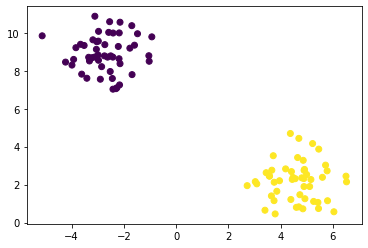

In [39]:
# Plot the blobs to visualize the 2 data centers
plt.scatter(X[:, 0], X[:, 1], c=y)

In [40]:
# Split, test, and train the dataset
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,
    y, random_state=1, stratify=y)

In [41]:
# Create the logistic regression model
from sklearn.linear_model import LogisticRegression
classifier = LogisticRegression(solver='lbfgs', random_state=1)
classifier

LogisticRegression(random_state=1)

In [42]:
# use fit() to train the logistic regression model
classifier.fit(X_train, y_train)

LogisticRegression(random_state=1)

In [43]:
# Make predictions of the data
predictions = classifier.predict(X_test)

# Visualize the predictions in a easy to read dataframe
pd.DataFrame({"Prediction": predictions, "Actual": y_test}).head()

,Prediction,Actual
0,1,1
1,0,0
2,1,1
3,1,1
4,1,1


In [44]:
# Get the accuracy score of the model
from sklearn.metrics import accuracy_score
accuracy_score(y_test, predictions)

1.0

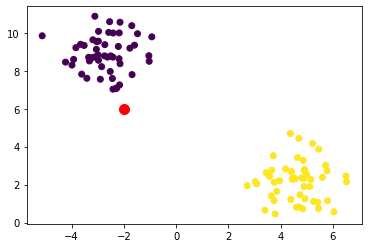

In [45]:
# Now we want to through new data into the model to see what it would predict
new_data = np.array([[-2, 6]])
plt.scatter(X[:, 0], X[:, 1], c=y)
plt.scatter(new_data[0, 0], new_data[0, 1], c="r", marker="o", s=100)
plt.show()

In [46]:
# pass the 'new_data' into the predict method of the classifier model that was instantiated earlier
predictions = classifier.predict(new_data)
print("Classes are either 0 (purple) or 1 (yellow)")
print(f"The new point was classified as: {predictions}")

Classes are either 0 (purple) or 1 (yellow)
The new point was classified as: [0]


In [49]:
hospital_data_df['hospital_bed_usage'] = hospital_data_df['all_adult_hospital_inpatient_bed_occupied_7_day_sum']/hospital_data_df['inpatient_beds_7_day_sum']
hospital_data_df

C:\Users\yremn\anaconda3\envs\mlenv\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,fips_code,collection_week,total_beds_7_day_sum,all_adult_hospital_beds_7_day_sum,all_adult_hospital_inpatient_beds_7_day_sum,inpatient_beds_used_7_day_sum,all_adult_hospital_inpatient_bed_occupied_7_day_sum,total_adult_patients_hospitalized_con_and_sus_covid_7_day_sum,total_adult_patients_hospitalized_con_covid_7_day_sum,total_ped_patients_hospitalized_con_and_sus_covid_7_day_sum,total_ped_patients_hospitalized_con_covid_7_day_sum,inpatient_beds_7_day_sum,total_icu_beds_7_day_sum,total_staffed_adult_icu_beds_7_day_sum,icu_beds_used_7_day_sum,staffed_adult_icu_bed_occupancy_7_day_sum,staffed_icu_adult_patients_con_and_sus_covid_7_day_sum,staffed_icu_adult_patients_con_covid_7_day_sum,fips_date,hospital_bed_usage
0,1001.0,2020-07-31,574,574,455,363,363,117,103,0,0,455,42,42,40,40,28,26,1001.02020-07-31,0.797802
1,1001.0,2020-08-07,574,574,455,369,369,153,139,0,0,455,42,42,41,41,38,37,1001.02020-08-07,0.810989
2,1001.0,2020-08-14,574,574,455,384,384,125,111,0,0,455,42,42,42,42,38,32,1001.02020-08-14,0.843956
3,1001.0,2020-08-21,574,574,455,348,348,86,74,0,0,455,42,42,38,38,48,35,1001.02020-08-21,0.764835
4,1001.0,2020-08-28,574,574,455,346,346,77,75,0,0,455,42,42,40,40,18,18,1001.02020-08-28,0.760440
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
159866,78020.0,2021-09-24,924,868,728,410,389,20,20,0,0,784,56,56,29,29,7,7,78020.02021-09-24,0.496173
159867,78020.0,2021-10-01,924,868,728,362,340,12,12,0,0,784,56,56,43,43,7,7,78020.02021-10-01,0.433673
159868,78020.0,2021-10-08,924,868,728,412,381,12,12,0,0,784,56,56,48,48,7,7,78020.02021-10-08,0.485969
159869,78020.0,2021-10-15,924,868,728,402,365,7,7,0,0,784,56,56,40,40,7,7,78020.02021-10-15,0.465561


In [51]:
hospital_data_df['hospital_bed_usage'].loc[hospital_data_df['hospital_bed_usage'] < 0.85] = 0
hospital_data_df['hospital_bed_usage'].loc[hospital_data_df['hospital_bed_usage'] >= 0.85] = 1
hospital_data_df

C:\Users\yremn\anaconda3\envs\mlenv\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\yremn\anaconda3\envs\mlenv\lib\site-packages\pandas\core\indexing.py:692: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)
C:\Users\yremn\anaconda3\envs\mlenv\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_

,fips_code,collection_week,total_beds_7_day_sum,all_adult_hospital_beds_7_day_sum,all_adult_hospital_inpatient_beds_7_day_sum,inpatient_beds_used_7_day_sum,all_adult_hospital_inpatient_bed_occupied_7_day_sum,total_adult_patients_hospitalized_con_and_sus_covid_7_day_sum,total_adult_patients_hospitalized_con_covid_7_day_sum,total_ped_patients_hospitalized_con_and_sus_covid_7_day_sum,total_ped_patients_hospitalized_con_covid_7_day_sum,inpatient_beds_7_day_sum,total_icu_beds_7_day_sum,total_staffed_adult_icu_beds_7_day_sum,icu_beds_used_7_day_sum,staffed_adult_icu_bed_occupancy_7_day_sum,staffed_icu_adult_patients_con_and_sus_covid_7_day_sum,staffed_icu_adult_patients_con_covid_7_day_sum,fips_date,hospital_bed_usage
0,1001.0,2020-07-31,574,574,455,363,363,117,103,0,0,455,42,42,40,40,28,26,1001.02020-07-31,0.0
1,1001.0,2020-08-07,574,574,455,369,369,153,139,0,0,455,42,42,41,41,38,37,1001.02020-08-07,0.0
2,1001.0,2020-08-14,574,574,455,384,384,125,111,0,0,455,42,42,42,42,38,32,1001.02020-08-14,0.0
3,1001.0,2020-08-21,574,574,455,348,348,86,74,0,0,455,42,42,38,38,48,35,1001.02020-08-21,0.0
4,1001.0,2020-08-28,574,574,455,346,346,77,75,0,0,455,42,42,40,40,18,18,1001.02020-08-28,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
159866,78020.0,2021-09-24,924,868,728,410,389,20,20,0,0,784,56,56,29,29,7,7,78020.02021-09-24,0.0
159867,78020.0,2021-10-01,924,868,728,362,340,12,12,0,0,784,56,56,43,43,7,7,78020.02021-10-01,0.0
159868,78020.0,2021-10-08,924,868,728,412,381,12,12,0,0,784,56,56,48,48,7,7,78020.02021-10-08,0.0
159869,78020.0,2021-10-15,924,868,728,402,365,7,7,0,0,784,56,56,40,40,7,7,78020.02021-10-15,0.0


In [59]:
# Get the counts for overloaded or not
hospital_data_df.dropna(inplace=True)
ml_model_df = hospital_data_df
ml_model_df.drop(['fips_date', 'fips_code', 'collection_week'], axis=1, inplace=True)
hospital_data_df['hospital_bed_usage'].value_counts()

C:\Users\yremn\anaconda3\envs\mlenv\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\yremn\anaconda3\envs\mlenv\lib\site-packages\pandas\core\frame.py:4315: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


0.0    145748
1.0     12700
Name: hospital_bed_usage, dtype: int64

In [60]:
# Create the model variables
X = ml_model_df.drop(['hospital_bed_usage'], axis=1)
y = ml_model_df['hospital_bed_usage']

In [61]:
# Split, Test, and Train the dataset
X_train, X_test, y_train, y_test = train_test_split(X,
    y, random_state=1, stratify=y)

In [62]:
# Create the logistic regression model
from sklearn.linear_model import LogisticRegression
classifier = LogisticRegression(solver='lbfgs', random_state=1)
classifier

LogisticRegression(random_state=1)

In [63]:
# use fit() to train the logistic regression model
classifier.fit(X_train, y_train)

C:\Users\yremn\anaconda3\envs\mlenv\lib\site-packages\sklearn\linear_model\_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


LogisticRegression(random_state=1)

In [64]:
# Make predictions of the data
predictions = classifier.predict(X_test)

In [65]:
# Get the accuracy score of the model
accuracy_score(y_test, predictions)

0.9997223063718065

In [66]:
# Print the confusion matrix
from sklearn.metrics import confusion_matrix, classification_report
matrix = confusion_matrix(y_test, predictions)
print(matrix)

[[36432     5]
 [    6  3169]]


In [67]:
# Get the classification report
report = classification_report(y_test, predictions)
print(report)

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     36437
         1.0       1.00      1.00      1.00      3175

    accuracy                           1.00     39612
   macro avg       1.00      1.00      1.00     39612
weighted avg       1.00      1.00      1.00     39612



# RandomOverSample

In [68]:
from imblearn.over_sampling import RandomOverSampler
ros = RandomOverSampler(random_state=1)
X_resampled, y_resampled = ros.fit_resample(X_train, y_train)

In [69]:
from collections import Counter
Counter(y_resampled)

Counter({0.0: 109311, 1.0: 109311})

In [70]:
# Rerun the model
model = LogisticRegression(solver='lbfgs', random_state=1)

model.fit(X_resampled, y_resampled)

y_pred = model.predict(X_test)
print(confusion_matrix(y_test, y_pred))

from sklearn.metrics import balanced_accuracy_score
print(balanced_accuracy_score(y_test, y_pred))

[[36414    23]
 [    2  3173]]
0.9993694261198112


C:\Users\yremn\anaconda3\envs\mlenv\lib\site-packages\sklearn\linear_model\_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [71]:
from imblearn.metrics import classification_report_imbalanced
print(classification_report_imbalanced(y_test, y_pred))

                   pre       rec       spe        f1       geo       iba       sup

        0.0       1.00      1.00      1.00      1.00      1.00      1.00     36437
        1.0       0.99      1.00      1.00      1.00      1.00      1.00      3175

avg / total       1.00      1.00      1.00      1.00      1.00      1.00     39612

